Visualization of the effects of the radial map (`pol2cart`) and of the inverse transformation (`cart2pol`).

In [1]:
from plotting import show_grid_plot
from plotting import cart2pol as cart2pol_plots
from plotting import pol2cart as pol2cart_plots

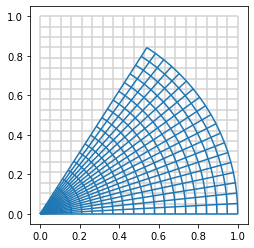

In [2]:
show_grid_plot(pol2cart_plots, multi_argument=True)

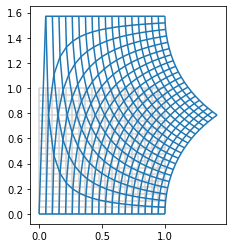

In [3]:
show_grid_plot(cart2pol_plots, multi_argument=True)

# Generate sources.

In [4]:
import jax
from jax import numpy as jnp
import numpy as np
import distrax
import haiku as hk
from residual import TriangularResidual, spectral_norm_init, spectral_normalization, masks_triangular_weights, make_weights_triangular, LipSwish

from jax.experimental.optimizers import adam

In [5]:
key = jax.random.PRNGKey(1)

In [6]:
import cmocean
cmap = cmocean.cm.phase

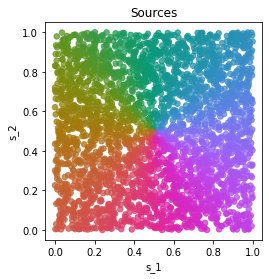

In [7]:
# N:=Number of samples
N = 3000
# D:=Number of dimensions
D = 2

# Generate the samples
S = jax.random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)


from plotting import cart2pol, pol2cart, scatterplot_variables

_, colors = cart2pol( S[:,0]-0.5, S[:,1]-0.5)

# Plot the sources
scatterplot_variables(S[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

# Import radial map

In [8]:
from mixing_functions import build_radial_map

In [9]:
# In order to select a rather mild nonlinear effect from the radial map, 
# we shift and rescale the source domain
rescale =  np.diag(np.array([0.7,0.35]))
add = jnp.array([1.8, 0.6])

In [10]:
pol2cart_mixing, cart2pol_unmixing = build_radial_map(add, rescale)

In [11]:
pol2cart_mixing_batched = jax.vmap(pol2cart_mixing)

In [12]:
X = pol2cart_mixing_batched(S)

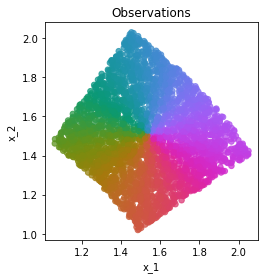

In [13]:
scatterplot_variables(X[:,:2], 'Observations', colors=colors, savefig=False, cmap=cmap)#True, fname="observations_flow")

Check that the inverse transformation works.

In [14]:
Y = jax.vmap(cart2pol_unmixing)(X)

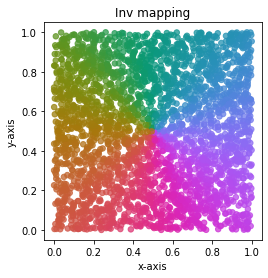

In [15]:
scatterplot_variables(Y[:,:2], 'Inv mapping', colors=colors, savefig=False, cmap=cmap)#True, fname="observations_flow")

Check that the $C_{\operatorname{IMA}}$ of the transformation is zero.

In [16]:
jac_pol2cart = jax.vmap(jax.jacfwd(cart2pol_unmixing))

In [17]:
from metrics import cima

In [18]:
jnp.mean(cima(X, jac_pol2cart))

DeviceArray(2.6812156e-08, dtype=float32)

Double check with $C_{\operatorname{IMA}}$ computed based on the _forward_ function and _sources_.

In [19]:
from metrics import cima_higher_d_fwd

In [20]:
jac_cart2pol = jax.vmap(jax.jacfwd(pol2cart_mixing))

In [21]:
np.mean(cima_higher_d_fwd(S, jac_cart2pol))

DeviceArray(-6.6856543e-09, dtype=float32)

## Define a Moebius transformations

In [22]:
from jax import vmap

In [23]:
S = jax.random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)

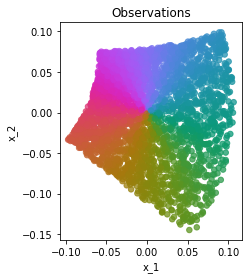

In [24]:
radius = 2 * np.sqrt(D)
a = jax.random.multivariate_normal(key, mean=np.zeros(D), cov=np.eye(D))
a /= jnp.mean(jnp.linalg.norm(a))
a *= radius

from mixing_functions import build_moebius_transform

# Generate a 2d rotation matrix based on a rotation angle
angle = 45
theta = np.radians(angle)
c, s = np.cos(theta), np.sin(theta)
A = np.array([[c, -s], [s, c]])
b = 0.0 * np.ones(D) # a vector in \RR^D
alpha = 1.0
epsilon = 2.0

mixing_moebius, _ = build_moebius_transform(alpha, A, a, b, epsilon=epsilon)
mixing_batched = vmap(mixing_moebius)

X = mixing_batched(S)
X_mean = np.mean(X, axis=0)
X-= X_mean
scatterplot_variables(X[:,:2], 'Observations', colors=colors, savefig=False, cmap=cmap)#True, fname="observations_flow")

b_new = b - X_mean
mixing_moebius, unmixing_moebius = build_moebius_transform(alpha, A, a, b_new, epsilon=epsilon)
unmixing_batched = vmap(unmixing_moebius)
mixing_batched = vmap(mixing_moebius)

In [25]:
jac_mixing = vmap(jax.jacfwd(mixing_moebius))

In [26]:
np.mean(cima_higher_d_fwd(S, jac_mixing))

DeviceArray(2.1457671e-09, dtype=float32)

In [27]:
jac_unmixing = vmap(jax.jacfwd(unmixing_moebius))

In [28]:
np.mean(cima(X, jac_unmixing))

DeviceArray(4.1325885e-09, dtype=float32)

# Composition radial map + Moebius transformation

In [36]:
def composed_radial_moebius(s):
    x_1 = pol2cart_mixing(s)
    return mixing_moebius(x_1)

def composed_radial_moebius_inverse(x):
    s_1 = unmixing_moebius(x)
    return cart2pol_unmixing(s_1)

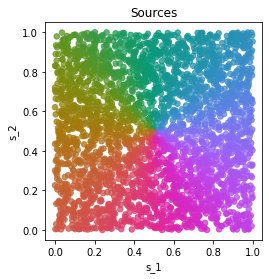

In [37]:
scatterplot_variables(S[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

In [38]:
composed_radial_moebius_batched = vmap(composed_radial_moebius)

In [39]:
X = composed_radial_moebius_batched(S)

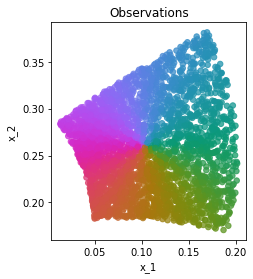

In [40]:
scatterplot_variables(X[:,:2], 'Observations', colors=colors, savefig=False, cmap=cmap)

In [41]:
S_ = vmap(composed_radial_moebius_inverse)(X)

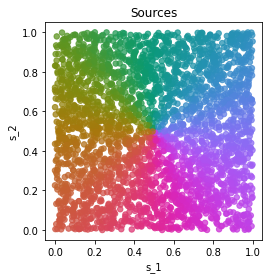

In [42]:
scatterplot_variables(S_[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

In [43]:
jac_composed = vmap(jax.jacfwd(composed_radial_moebius))

In [44]:
np.mean(cima_higher_d_fwd(S, jac_composed))

DeviceArray(1.7484029e-09, dtype=float32)

In [45]:
jac_inv_composed = vmap(jax.jacfwd(composed_radial_moebius_inverse))

In [46]:
np.mean(cima(X, jac_inv_composed))

DeviceArray(7.23203e-09, dtype=float32)